# When will the German TARGET-Salden hit the 1 trillion euro mark?

The German TARGET-Salden have already bounced several times past the psychologically important 1 trillion euro mark (as they would say in M20), it shouldn't be long before this support breaks.

Here I would use a time series forecasting model to make an estimate. One such model is the autoregressive integrated moving average (ARIMA) model. The historical data used is the TARGET monthly average position from 2008 June to 2023 October.

**Data Source**: [External position of the Bundesbank - Assets - Other Investment - Currency and deposits - TARGET2 (net) - monthly averages based on TARGET2 business days till 2023-10](https://www.bundesbank.de/dynamic/action/en/statistics/time-series-databases/time-series-databases/745582/745582?treeAnchor=AUSSENWIRTSCHAFT&tsTab=0&tsId=BBFI1.M.N_A1.DE.4F.S121.S1.LE.A.FA.O.F221T.S._T.N.N&statisticType=BBK_ITS&dateSelect=2023)

### References
- [A Real-World Time Series Forecasting: Daily Average Exchange Rates](https://towardsdatascience.com/a-real-world-time-series-data-analysis-and-forecasting-121f4552a87)
- [ARIMA models](https://otexts.com/fpp2/arima.html)


In [1]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller


# Load the data into a pandas DataFrame from the Bundesbank csv file and skip the first 8 lines
data = pd.read_csv('TARGET2_DE_monthly_200806-202310.csv', parse_dates=True)

# Skip the first 8 lines and the last column
data = data.iloc[8:, :-1]

# Skip the first 153 lines, begin from 2020-07
# data = data.iloc[153:, :-1]

# Assign names to the columns
data.columns = ['month', 'average_position']
data['average_position'] = pd.to_numeric(data['average_position'])

# Set the "month" column as index column
data = data.set_index('month')

# Print the DataFrame
print(data)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


         average_position
month                    
2008-06         91250.626
2008-07        100452.660
2008-08        105434.623
2008-09        102308.935
2008-10         94577.183
...                   ...
2023-06       1065418.434
2023-07       1042005.552
2023-08       1041412.325
2023-09       1046653.387
2023-10       1045764.063

[185 rows x 1 columns]


Next, we need to plot the **autocorrelation function (ACF)** and **partial autocorrelation function (PACF)** of the data to identify the order of the ARIMA model.

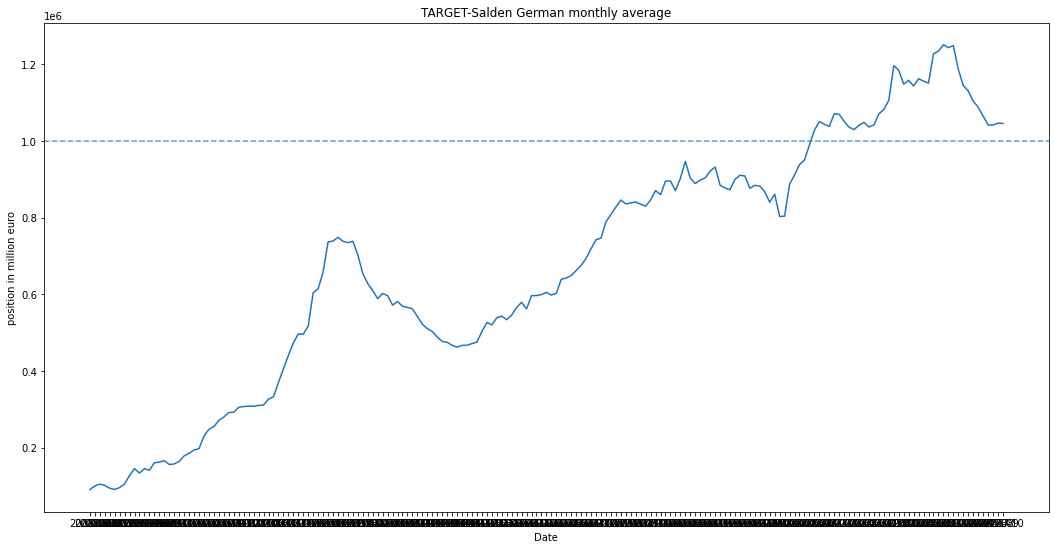

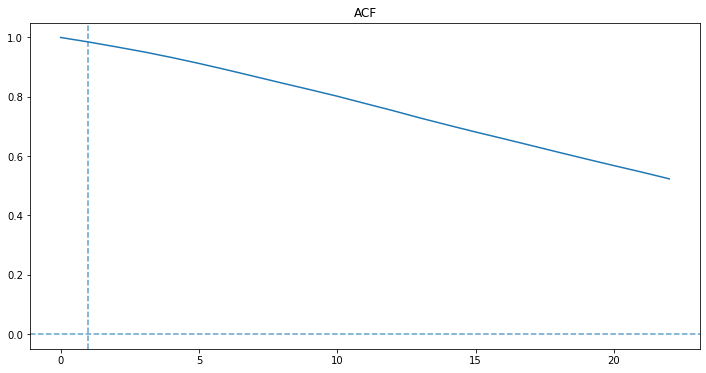

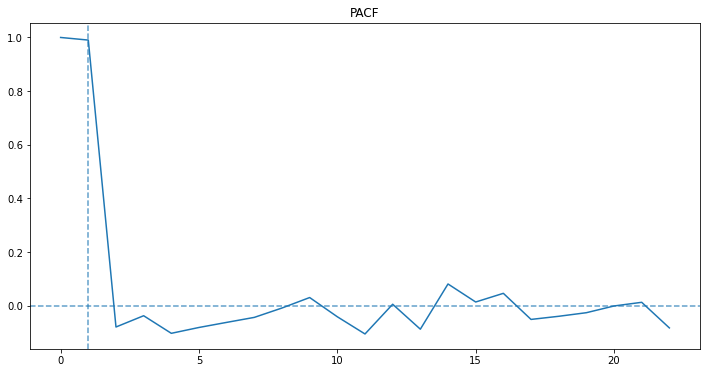

In [2]:
import matplotlib.pyplot as plt

# Plot the time series
plt.figure(figsize=(18, 9))
plt.plot(data['average_position'])
plt.axhline(y=1e6, linestyle='--', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('position in million euro')
plt.title('TARGET-Salden German monthly average')
plt.show()

# Plot the ACF
plt.figure(figsize=(12, 6))
plt.plot(sm.tsa.stattools.acf(data['average_position']))
plt.axhline(y=0, linestyle='--', alpha=0.7)
plt.axvline(x=1, linestyle='--', alpha=0.7)
plt.title('ACF')
plt.show()

# Plot the PACF
plt.figure(figsize=(12, 6))
plt.plot(sm.tsa.stattools.pacf(data['average_position']))
plt.axhline(y=0, linestyle='--', alpha=0.7)
plt.axvline(x=1, linestyle='--', alpha=0.7)
plt.title('PACF')
plt.show()

## Interpretation of the ACF and PACF plots

1. **ACF Plot**: The ACF has no significant spike at any lag and it falls smoothly over a long period, it suggests that the series has a strong autoregressive component. In other words, the current value of the series is likely influenced by its past values, but this influence declines smoothly over time.

2. **PACF Plot**: A significant spike at lag 1 in the PACF plot suggests that there is a strong correlation between an observation and its immediate previous value, after accounting for the correlations at shorter lags. This is a characteristic of an autoregressive process of order 1.

Given these observations, we might consider the following order for the ARIMA model:

- **AR (p) - Autoregressive term**: The spike in the PACF at lag 1 suggests an AR(1) model. This means we should consider using one autoregressive term in your model (`p = 1`).

- **I (d) - Integrated term**: The order of differencing (d) depends on whether the series is stationary or not. If this series is not stationary, we will need to difference it, and the order of differencing will depend on how many times you need to difference the series to make it stationary.

- **MA (q) - Moving Average term**: The smooth decay in the ACF plot does not suggest a strong need for a moving average component. However, sometimes a small MA term (like MA(1)) is added for better modeling. We might start with `q = 0` and consider testing a `q = 1` if the model's fit is not satisfactory.

Therefore, a starting point could be an `ARIMA(1, d, 0)` or `ARIMA(1, d, 1)` model, where 'd' is determined based on the stationarity of this series.

Now let's difference our series.

In [3]:
def determine_differencing_order(time_series):
    series = pd.Series(time_series)
    d = 0
    while True:
        # Run Augmented Dickey-Fuller test to check stationarity
        result = adfuller(series)
        if result[1] <= 0.05:
            break
        d += 1
        series = series.diff(1)
        
        # Drop NaN values created by differencing
        series = series.dropna()
    return d


# Determine the order of differencing (d)
d = determine_differencing_order(data['average_position'])

print('Order of differencing (d):', d)

Order of differencing (d): 1


In [4]:
# Now we have determined the paramters for ARIMA, let's fit the model, first with the MA order of 0. 
model_q0 = sm.tsa.arima.ARIMA(data['average_position'], order=(1, 1, 0))
model_q0_fit = model_q0.fit()

# Print the model summary
print(model_q0_fit.summary())

                               SARIMAX Results                                
Dep. Variable:       average_position   No. Observations:                  185
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -2104.931
Date:                Wed, 22 Nov 2023   AIC                           4213.862
Time:                        18:34:23   BIC                           4220.292
Sample:                    06-01-2008   HQIC                          4216.468
                         - 10-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2861      0.065      4.434      0.000       0.160       0.413
sigma2       5.07e+08   1.88e-11    2.7e+19      0.000    5.07e+08    5.07e+08
Ljung-Box (L1) (Q):                   0.21   Jarque-

In [5]:
# Now with the MA order of 1. 
model_q1 = sm.tsa.arima.ARIMA(data['average_position'], order=(1, 1, 1))
model_q1_fit = model_q1.fit()

# Print the model summary
print(model_q1_fit.summary())

                               SARIMAX Results                                
Dep. Variable:       average_position   No. Observations:                  185
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2101.870
Date:                Wed, 22 Nov 2023   AIC                           4209.741
Time:                        18:34:28   BIC                           4219.386
Sample:                    06-01-2008   HQIC                          4213.650
                         - 10-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7986      0.111      7.169      0.000       0.580       1.017
ma.L1         -0.5978      0.159     -3.769      0.000      -0.909      -0.287
sigma2      5.046e+08   8.66e-11   5.83e+18      0.0

In [6]:
# Make predictions with q=0
start_date = pd.to_datetime('2023-11-01')
end_date = pd.to_datetime('2024-12-31')

predictions_q0 = model_q0_fit.forecast(steps=12)
dates = pd.date_range(start_date, end_date, freq='M')

print(predictions_q0)

2023-11-01    1.045510e+06
2023-12-01    1.045437e+06
2024-01-01    1.045416e+06
2024-02-01    1.045410e+06
2024-03-01    1.045408e+06
2024-04-01    1.045408e+06
2024-05-01    1.045408e+06
2024-06-01    1.045408e+06
2024-07-01    1.045408e+06
2024-08-01    1.045408e+06
2024-09-01    1.045408e+06
2024-10-01    1.045408e+06
Freq: MS, Name: predicted_mean, dtype: float64


In [7]:
# Make predictions with q=1
predictions_q1 = model_q1_fit.forecast(steps=12)
dates = pd.date_range(start_date, end_date, freq='M')

print(predictions_q1)

2023-11-01    1.043782e+06
2023-12-01    1.042199e+06
2024-01-01    1.040935e+06
2024-02-01    1.039926e+06
2024-03-01    1.039120e+06
2024-04-01    1.038476e+06
2024-05-01    1.037962e+06
2024-06-01    1.037552e+06
2024-07-01    1.037224e+06
2024-08-01    1.036962e+06
2024-09-01    1.036753e+06
2024-10-01    1.036586e+06
Freq: MS, Name: predicted_mean, dtype: float64
